In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import skimage
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

# function to create and save patches
def create_patches(image_path, patch_size=(256, 256), save_dir='/content/patches'):

    # Load the image
    image = cv2.imread(image_path)
    image = image[400:1600, 900:3400]

    # image dimensions
    img_height, img_width, _ = image.shape

    # patch dimensions
    patch_height, patch_width = patch_size

    # Create the directory to save patches
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # patch counter
    patch_counter = 0

    # Loop to create patches
    for y in range(0, img_height, patch_height):
        for x in range(0, img_width, patch_width):

            patch = image[y:y + patch_height, x:x + patch_width]

            patch_filename = os.path.join(save_dir, f'patch_{patch_counter}.png')
            cv2.imwrite(patch_filename, patch)

            patch_counter += 1
            print(f'Saved: {patch_filename}')

# path to the image and patch size
image_path = '/content/drive/MyDrive/Datasets/measurementDataset/measurement_image_1.tif'
patch_size = (256, 256)

# Create and save patches
create_patches(image_path, patch_size)


Saved: /content/patches/patch_0.png
Saved: /content/patches/patch_1.png
Saved: /content/patches/patch_2.png
Saved: /content/patches/patch_3.png
Saved: /content/patches/patch_4.png
Saved: /content/patches/patch_5.png
Saved: /content/patches/patch_6.png
Saved: /content/patches/patch_7.png
Saved: /content/patches/patch_8.png
Saved: /content/patches/patch_9.png
Saved: /content/patches/patch_10.png
Saved: /content/patches/patch_11.png
Saved: /content/patches/patch_12.png
Saved: /content/patches/patch_13.png
Saved: /content/patches/patch_14.png
Saved: /content/patches/patch_15.png
Saved: /content/patches/patch_16.png
Saved: /content/patches/patch_17.png
Saved: /content/patches/patch_18.png
Saved: /content/patches/patch_19.png
Saved: /content/patches/patch_20.png
Saved: /content/patches/patch_21.png
Saved: /content/patches/patch_22.png
Saved: /content/patches/patch_23.png
Saved: /content/patches/patch_24.png
Saved: /content/patches/patch_25.png
Saved: /content/patches/patch_26.png
Saved: /con

In [4]:
# Custom loss and metrics functions
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives + K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
        total = K.sum(K.square(y_true), [1, 2, 3]) + K.sum(K.square(y_pred), [1, 2, 3])
        union = total - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(f(y_true, y_pred), axis=-1)



In [5]:
# Function to preprocess input patch
def preprocess_patch(patch, img_size):
    patch = patch / 255.0  # Normalize the patch
    patch = cv2.resize(patch, (img_size, img_size))
    patch = np.expand_dims(patch, axis=-1)  # Add channel dimension
    return patch

# Function to postprocess prediction to binary mask
def postprocess_prediction(pred):
    return (pred > 0.8).astype(np.uint8)

# Function to label instances
def label_instances(binary_mask):
    num_labels, labels_im = cv2.connectedComponents(binary_mask)
    return labels_im

# visualize results
def visualize_instance_segmentation(input_image, binary_mask, labeled_mask):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(input_image, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(binary_mask, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Instance Segmentation")
    plt.imshow(labeled_mask, cmap='nipy_spectral')

    plt.show()


In [7]:
# Load the trained model
root_model = load_model('/content/root_model.h5', custom_objects={'f1': f1, 'iou': iou})

1/1 [==============================] - 0s 165ms/step


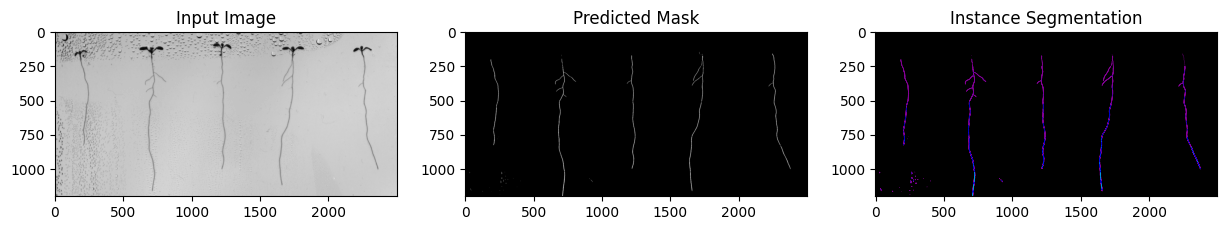

In [8]:
# Path to the patches directory
patches_dir = '/content/patches'
img_size = 256

# Load the original image to get its dimensions
image_path = '/content/drive/MyDrive/Datasets/measurementDataset/measurement_image_1.tif'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
original_image = original_image[400:1600, 900:3400]
img_height, img_width = original_image.shape

# Initialize an empty array to hold the combined predictions
combined_pred = np.zeros((img_height, img_width), dtype=np.float32)

# Process each patch
patch_counter = 0
for y in range(0, img_height, img_size):
    for x in range(0, img_width, img_size):
        # Load the patch
        patch_path = os.path.join(patches_dir, f'patch_{patch_counter}.png')
        patch = cv2.imread(patch_path, cv2.IMREAD_GRAYSCALE)
        input_patch = preprocess_patch(patch, img_size)

        binary_mask_pred = root_model.predict(np.expand_dims(input_patch, axis=0))[0, :, :, 0]

        combined_pred[y:y + img_size, x:x + img_size] = binary_mask_pred[:img_height-y, :img_width-x]

        patch_counter += 1

# Postprocess the combined predictions
combined_binary_mask = postprocess_prediction(combined_pred)

# Label instances in the combined binary mask
combined_labeled_mask = label_instances(combined_binary_mask)

# Visualize the results
visualize_instance_segmentation(original_image, combined_binary_mask, combined_labeled_mask)